<a href="https://colab.research.google.com/github/kev065/dsc-word-vectorization-lab/blob/master/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Vectorization - Lab

## Introduction

In this lab, you'll tokenize and vectorize text documents, create and use a bag of words, and identify words unique to individual documents using TF-IDF vectorization.


## Objectives

In this lab you will:  

- Implement tokenization and count vectorization from scratch
- Implement TF-IDF from scratch
- Use dimensionality reduction on vectorized text data to create and interpret visualizations

## Let's get started!

Run the cell below to import everything necessary for this lab.  

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt', quiet=True)
np.random.seed(0)

### Our Corpus

In this lab, we'll be working with 20 different documents, each containing song lyrics from either Garth Brooks or Kendrick Lamar albums.  

The songs are contained within the `data` subdirectory, contained within the same folder as this lab.  Each song is stored in a single file, with files ranging from `song1.txt` to `song20.txt`.  

To make it easy to read in all of the documents, use a list comprehension to create a list containing the name of every single song file in the cell below.

In [2]:
filenames = ['song'+str(num)+'.txt' for num in range(1,21)]

import requestsNext, let's import a single song to see what our text looks like so that we can make sure we clean and tokenize it correctly.

Use the code in the cell below to read in the lyrics from `song18.txt` as a list of lines, just using vanilla Python:

In [7]:
import requests

url = "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song18.txt"

# Fetch and read the file
response = requests.get(url)
test_song = response.text.splitlines()

# Print the content
print(test_song)

['[Kendrick Lamar:]', "Two wrongs don't make us right away", "Tell me something's wrong", 'Party all of our lives away', 'To take you on', '[Zacari:]', 'Oh, baby I want you', 'Baby I need you', 'I wanna see you', 'Baby I wanna go out yeah', 'Baby I wanna go out yeah', 'Baby I want you', 'Baby I need you', 'I wanna see you', 'Baby I wanna go out yeah', 'Baby I wanna go out yeah', 'All night (all night, all night)', 'All night', "Your body's on fire", 'And your drinks on ice', 'All night (all night, all night)', 'All night', "Your body's on fire", 'And your drinks on ice', '[Babes Wodumo:]', 'Oh my word oh my gosh oh my word (Oh my gosh)', 'Oh my word oh my gosh oh my word (Oh my gosh)', 'Oh my word oh my gosh oh my word (Oh my gosh)', 'Oh my word oh my gosh oh my word (Oh my gosh)', 'Everybody say kikiritikiki (kikiritikiki)', 'Everybody say kikiritikiki (kikiritikiki)', 'Everybody say kikiritikiki (kikiritikiki)', 'Everybody say kikiritikiki (kikiritikiki)', "Ung'bambe, ung'dedele. Ung

### Tokenizing our Data

Before we can create a bag of words or vectorize each document, we need to clean it up and split each song into an array of individual words.

Consider the following sentences from the example above:

`"Two wrongs don't make us right away\n", "Tell me something's wrong\n"`

After tokenization, this should look like:

`['two', 'wrongs', 'dont', 'make', 'us', 'right', 'away', 'tell', 'me', 'somethings', 'wrong']`

Tokenization is pretty tedious if we handle it manually, and would probably make use of regular expressions, which is outside the scope of this lab. In order to keep this lab moving, we'll use a library function to clean and tokenize our data so that we can move onto vectorization.  

Tokenization is a required task for just about any Natural Language Processing (NLP) task, so great industry-standard tools exist to tokenize things for us, so that we can spend our time on more important tasks without getting bogged down hunting every special symbol or punctuation in a massive dataset. For this lab, we'll make use of the tokenizer in the amazing `nltk` library, which is short for _Natural Language Tool Kit_.

**_NOTE:_** NLTK requires extra installation methods to be run the first time certain methods are used.  If `nltk` throws you an error about needing to install additional packages, follow the instructions in the error message to install the dependencies, and then rerun the cell.  

Before we tokenize, however, we need to do one more step! Computers are very particular about strings. If we tokenized our data in its current state, we would run into the following problems:

- Counting things that aren't actually words.  In the example above, `"[Kendrick Lamar:]"` is a note specifying who is speaking, not a lyric contained in the actual song, so it should be removed.
- Punctuation and capitalization would mess up our word counts. To the Python interpreter, `all`, `All`, and `(all` are unique words, and would all be counted separately.  We need to remove punctuation and capitalization, so that all words will be counted correctly.

Before we tokenize our songs, we'll do only a small manual bit of cleaning.

In the cell below, write a function to:
- remove lines that just contain `['artist names']`
- join the list of strings into one big string for the entire song
- remove newline characters `\n`
- remove the following punctuation marks: `",.'?!()"`
- make every word lowercase

Test the function on `test_song` to show that it has successfully removed `'[Kendrick Lamar:]'` and other instances of artist names from the song, and is returning the song as one string (NOT a list of strings) with newlines (`\n`) and punctuation removed and every word in lowercase.

In [8]:
def clean_song(song):
    for line in song:
        if '[' in line and ']' in line:
            song.remove(line)
    song = ' '.join(test_song)
    song = song.replace('\n', '')
    punct = [",", ".", "'", "?", "!", "(", ")"]
    for p in punct:
        song = song.replace(p, '')
    song = song.lower()
    return song

clean_test_song = clean_song(test_song)
print(clean_test_song)

two wrongs dont make us right away tell me somethings wrong party all of our lives away to take you on oh baby i want you baby i need you i wanna see you baby i wanna go out yeah baby i wanna go out yeah baby i want you baby i need you i wanna see you baby i wanna go out yeah baby i wanna go out yeah all night all night all night all night your bodys on fire and your drinks on ice all night all night all night all night your bodys on fire and your drinks on ice oh my word oh my gosh oh my word oh my gosh oh my word oh my gosh oh my word oh my gosh oh my word oh my gosh oh my word oh my gosh oh my word oh my gosh oh my word oh my gosh everybody say kikiritikiki kikiritikiki everybody say kikiritikiki kikiritikiki everybody say kikiritikiki kikiritikiki everybody say kikiritikiki kikiritikiki ungbambe ungdedele ungbhasobhe unggudluke ungbambe ungdedele ungbhasobhe unggudluke ungbambe ungdedele ungbhasobhe unggudluke ungbambe ungdedele ungbhasobhe unggudluke baby i want you baby i need yo

Great! Now, we can use `nltk`'s `word_tokenize()` function on the song string to get a fully tokenized version of the song. Test this function on `clean_test_song` to ensure that the function works.

In [9]:
tokenized_test_song = word_tokenize(clean_test_song)

Great! Now that we can tokenize our songs, we can move onto vectorization.


### Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices.  By **_Vectorizing_** the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus.  Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence.

Consider the following example:

<center>"I scream, you scream, we all scream for ice cream."</center>

| 'aardvark' | 'apple' | [...] | 'I' | 'you' | 'scream' | 'we' | 'all' | 'for' | 'ice' | 'cream' | [...] | 'xylophone' | 'zebra' |
|:----------:|:-------:|:-----:|:---:|:-----:|:--------:|:----:|:-----:|:-----:|:-----:|:-------:|:-----:|:-----------:|:-------:|
|      0     |    0    |   0   |  1  |   1   |     3    |   1  |   1   |   1   |   1   |    1    |   0   |      0      |    0    |

This is called a **_Sparse Representation_**, since the strong majority of the columns will have a value of 0.  Note that elements corresponding to words that do not occur in the sentence have a value of 0, while words that do appear in the sentence have a value of 1 (or 1 for each time it appears in the sentence).

Alternatively, we can represent this sentence as a plain old Python dictionary of word frequency counts:

```python
BoW = {
    'I':1,
    'you':1,
    'scream':3,
    'we':1,
    'all':1,
    'for':1,
    'ice':1,
    'cream':1
}
```

Both of these are examples of **_Count Vectorization_**. They allow us to represent a sentence as a vector, with each element in the vector corresponding to how many times that word is used.

#### Positional Information and Bag of Words

Notice that when we vectorize a sentence this way, we lose the order that the words were in.  This is the **_Bag of Words_** approach mentioned earlier.  Note that sentences that contain the same words will create the same vectors, even if they mean different things -- e.g. `'cats are scared of dogs'` and `'dogs are scared of cats'` would both produce the exact same vector, since they contain the same words.  

In the cell below, create a function that takes in a tokenized, cleaned song and returns a count vectorized representation of it as a Python dictionary.

**_Hint:_**  Consider using a `set()` since you'll need each unique word in the tokenized song!

In [10]:
def count_vectorize(tokenized_song):
    token_counts = {}
    for token in tokenized_song:
        if token not in token_counts:
            token_counts[token] = 1
        else:
            token_counts[token] += 1
    return token_counts

test_vectorized = count_vectorize(tokenized_test_song)
print(test_vectorized)

{'two': 1, 'wrongs': 1, 'dont': 1, 'make': 1, 'us': 1, 'right': 1, 'away': 2, 'tell': 1, 'me': 1, 'somethings': 1, 'wrong': 1, 'party': 1, 'all': 25, 'of': 1, 'our': 1, 'lives': 1, 'to': 1, 'take': 1, 'you': 19, 'on': 13, 'oh': 17, 'baby': 24, 'i': 30, 'want': 6, 'need': 6, 'wan': 18, 'na': 18, 'see': 6, 'go': 13, 'out': 12, 'yeah': 12, 'night': 24, 'your': 12, 'bodys': 6, 'fire': 6, 'and': 6, 'drinks': 6, 'ice': 6, 'my': 16, 'word': 8, 'gosh': 8, 'everybody': 4, 'say': 4, 'kikiritikiki': 8, 'ungbambe': 4, 'ungdedele': 4, 'ungbhasobhe': 4, 'unggudluke': 4, 'we': 1, 'high': 16, 'up': 16, '[': 1, 'zacari': 1, ':': 1, ']': 1}


Great! You've just successfully vectorized your first text document! Now, let's look at a more advanced type of vectorization, TF-IDF!

### TF-IDF Vectorization

TF-IDF stands for **_Term Frequency, Inverse Document Frequency_**.  This is a more advanced form of vectorization that weighs each term in a document by how unique it is to the given document it is contained in, which allows us to summarize the contents of a document using a few key words.  If the word is used often in many other documents, it is not unique, and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents. Conversely, if a word is used many times in a document, but rarely in all the other documents we are considering, then it is likely a good indicator for telling us that this word is important to the document in question.  

The formula TF-IDF uses to determine the weights of each term in a document is **_Term Frequency_** multiplied by **_Inverse Document Frequency_**. We just calculated our Term Frequency above with Count Vectorization!

Now that we have this, we can easily calculate _Inverse Document Frequency_. Note that this will need ALL of our documents (aka our songs), not just an individual document - so we'll put off testing this function for now.

In the cell below, complete a function that takes in a list of tokenized songs, with each item in the list being a clean, tokenized version of the song. The function should return a dictionary containing the inverse document frequency values for each word.  

The formula for Inverse Document Frequency is:  
<br>  
<br>
$$\large \text{IDF}(t) =  log_e(\frac{\text{Total Number of Documents}}{\text{Number of Documents with } t \text{ in it}})$$

In [11]:
def inverse_document_frequency(list_of_token_songs):
    idf_dict = {}
    total_docs = len(list_of_token_songs)
    doc_word_count = {}
    for song in list_of_token_songs:
        for word in song:
            if word not in doc_word_count:
                doc_word_count[word] = 1
            else:
                doc_word_count[word] += 1
        idf_dict[word] = np.log(total_docs / doc_word_count[word])
    return idf_dict

### Computing TF-IDF

Now that we can compute both Term Frequency and Inverse Document Frequency, computing an overall TF-IDF value is simple! All we need to do is multiply the two values.  

In the cell below, complete the `tf_idf()` function.  This function should take in a list of tokenized songs, just as the `inverse_document_frequency()` function did.  This function returns a new list of dictionaries, with each dictionary containing the tf-idf vectorized representation of a corresponding song document. You'll need to calculate the term frequency for each song using the `count_vectorize()` function we defined above.

**_NOTE:_** Each document should contain the full vocabulary of the entire combined corpus! So, even if a song doesn't have the word "kikiritikiki" (a vocalization in our test song), it should have a dictionary entry with that word as the key and `0` as the value.

In [12]:
def tf_idf(list_of_token_songs):
    tf_idf_list = []
    unique_words = []
    for token_song in list_of_token_songs:
        for word in token_song:
            if word not in unique_words:
                unique_words.append(word)
    idf = inverse_document_frequency(list_of_token_songs)

    for song in list_of_token_songs:
        tf = count_vectorize(song)
        tf_idf = {word:0 for word in unique_words}
        for word in unique_words:
            if word in song:
                tf_idf[word] = tf[word] * idf[word]
            else:
                tf_idf[word] = 0
        tf_idf_list.append(tf_idf)

    return tf_idf_list

### Vectorizing All Documents

Now that we've created all the necessary helper functions, we can load in all of our documents and run each through the vectorization pipeline we've just created.

In the cell below, complete the `main()` function.  This function should take in a list of file names (provided for you in the `filenames` list we created at the start), and then:

- Read in each document into a list of raw songs (where each song is a list of strings)
- Tokenize each document into a list of cleaned and tokenized songs
- Return a list of dictionaries vectorized using `tf-idf`, where each dictionary is a vectorized representation of each song

In [14]:
# GitHub raw content URLs
GITHUB_RAW_URLS = [
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/lyrics_helper.py",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/lyrics_url.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song1.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song10.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song11.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song12.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song13.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song14.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song15.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song16.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song17.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song18.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song19.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song2.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song20.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song3.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song4.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song5.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song6.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song7.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song8.txt",
    "https://raw.githubusercontent.com/kev065/dsc-word-vectorization-lab/master/data/song9.txt"
]

In [16]:
import requests
from nltk import word_tokenize
from math import log

def fetch_github_content(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text.splitlines()
    else:
        print(f"Failed to fetch content from {url}")
        return []

def clean_song(song):
    # song cleaning
    return ' '.join(song).lower()

def tf_idf(list_of_token_songs):
    tf_idf_list = []
    idf = {}
    unique_words = set(word for song in list_of_token_songs for word in song)

    # Calculate IDF
    for word in unique_words:
        idf[word] = log(len(list_of_token_songs) / sum(1 for song in list_of_token_songs if word in song))

    for song in list_of_token_songs:
        tf = {}
        for word in song:
            tf[word] = tf.get(word, 0) + 1

        # Normalize TF
        for word in tf:
            tf[word] = tf[word] / len(song)

        tf_idf = {}
        for word in unique_words:
            if word in tf:
                tf_idf[word] = tf[word] * idf[word]
            else:
                tf_idf[word] = 0

        tf_idf_list.append(tf_idf)

    return tf_idf_list

def main(github_urls):
    # Fetch raw songs from GitHub links
    raw_songs = []
    for url in github_urls:
        song = fetch_github_content(url)
        raw_songs.append(clean_song(song))

    # Tokenize each document into a list of cleaned and tokenized songs
    tokenized_songs = []
    for song in raw_songs:
        tokenized_songs.append(word_tokenize(song))

    # Create list of dictionaries vectorized using tf-idf
    tf_idf_list = tf_idf(tokenized_songs)
    return tf_idf_list

tf_idf_all_docs = main(GITHUB_RAW_URLS)

### Level Up: Visualizing our Vectorizations (Optional)

Now that we have a tf-idf representation of each document, we can move on to the fun part -- visualizing everything!

In the cell below, examine our dictionaries to figure out how many dimensions our dataset has.

**_HINT_**: Remember that every word is its own dimension!

In [19]:
vocab = list(tf_idf_all_docs[0].keys())
num_dims = len(vocab)
# Same as:
# num_dims = len(tf_idf_all_docs[0])
print(f"Number of Dimensions: {num_dims}")

Number of Dimensions: 1414


There are too many dimensions for us to visualize! In order to make it understandable to human eyes, we'll need to reduce it to 2 or 3 dimensions.  

To do this, we'll use a technique called **_t-SNE_** (short for _t-Stochastic Neighbors Embedding_).  This is too complex for us to code ourselves, so we'll make use of scikit-learn's implementation of it.  

First, we need to pull the words out of the dictionaries stored in `tf_idf_all_docs` so that only the values remain, and store them in lists instead of dictionaries.  This is because the t-SNE only works with array-like objects, not dictionaries.  

In the cell below, create a list of lists that contains a list representation of the values of each of the dictionaries stored in `tf_idf_all_docs`.  The same structure should remain -- e.g. the first list should contain only the values that were in the first dictionary in `tf_idf_all_docs`, and so on.

In [20]:
tf_idf_vals_list = []

for i in tf_idf_all_docs:
    tf_idf_vals_list.append(list(i.values()))

tf_idf_vals_list[0][:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Now that we have only the values, we can use the `TSNE()` class from `sklearn` to transform our data appropriately. In the cell below, instantiate `TSNE()` with the following arguments:
- `n_components=3` (so we can compare 2 vs 3 components when graphing)
- `perplexity=19` (the highest number of neighbors explored given the size of our dataset)
- `learning_rate=200` (a higher learning rate than using 'auto', to avoid getting stuck in a local minimum)
- `init='random'` (so SKLearn will randomize the initialization)
- `random_state=13` (so that random initialization won't be TOO random)

Then, use the created object's `.fit_transform()` method to transform the data stored in `tf_idf_vals_list` into 3-dimensional data.  Then, inspect the newly transformed data to confirm that it has the correct dimensionality.

In [21]:
t_sne_object_3d = TSNE(n_components = 3,
                       perplexity = 19,
                       learning_rate = 200,
                       init = 'random',
                       random_state = 13)

transformed_data_3d = t_sne_object_3d.fit_transform(np.array(tf_idf_vals_list))
transformed_data_3d

array([[  31.076735 , -231.14615  , -190.68033  ],
       [  14.181195 , -160.65303  ,  276.3188   ],
       [  15.29362  ,   35.549576 , -800.17126  ],
       [-455.24435  , -233.38246  ,  479.61746  ],
       [-154.02884  ,  -99.51452  ,   14.561801 ],
       [ -84.00051  ,   94.73457  ,  186.17767  ],
       [ 463.399    ,  268.2445   , -211.68358  ],
       [  57.868084 ,  268.38132  ,   62.96937  ],
       [-329.9486   ,   89.209305 ,  207.11537  ],
       [-145.44086  ,  161.91943  , -114.71035  ],
       [  28.321932 , -107.2441   ,  518.4178   ],
       [ 202.5104   ,  243.7829   , -183.31837  ],
       [ 436.26367  ,  -78.351585 , -183.25554  ],
       [-228.6303   , -315.50165  ,  108.76423  ],
       [ 399.66544  , -328.33377  ,  269.3216   ],
       [-411.5335   ,  219.11423  , -138.60266  ],
       [-264.1087   ,  -83.15579  , -222.61885  ],
       [  49.45188  ,  459.73273  , -298.42566  ],
       [ 320.5014   ,   12.084228 ,   39.90881  ],
       [ 106.3568   ,  -91.4845

We'll also want to check out how the visualization looks in 2d.  Repeat the process above, but this time, instantiate `TSNE()` with 2 components instead of 3.  Again, use `.fit_transform()` to transform the data and store it in the variable below, and then inspect it to confirm the transformed data has only 2 dimensions.

In [24]:
t_sne_object_2d = TSNE(n_components = 2,
                       perplexity = 19,
                       learning_rate = 200,
                       init = 'random',
                       random_state = 13)
transformed_data_2d = t_sne_object_2d.fit_transform(np.array(tf_idf_vals_list))
transformed_data_2d

array([[-181.4468   ,  169.8434   ],
       [ 147.85126  , -199.85947  ],
       [  95.37857  ,   12.638154 ],
       [  37.53926  ,  -43.01911  ],
       [-146.75502  ,   62.269756 ],
       [ -34.108795 ,  -91.64753  ],
       [  44.933075 , -125.227554 ],
       [-122.09377  ,  -17.883574 ],
       [  62.789463 ,   86.12412  ],
       [  12.331681 ,   30.07663  ],
       [ -45.045414 , -188.92566  ],
       [ 183.18494  ,    3.4396589],
       [-123.32105  , -104.29419  ],
       [ -86.01163  ,  136.79092  ],
       [ -43.627205 ,  -18.604502 ],
       [-238.49223  ,  -20.56158  ],
       [ 123.99124  ,  -73.52792  ],
       [  85.31853  ,  174.31416  ],
       [ -10.582757 ,  193.70583  ],
       [ -64.28842  ,   54.266052 ],
       [ 144.60333  ,   93.628044 ],
       [  -7.542995 ,  110.127106 ]], dtype=float32)

Now, let's visualize everything!  Run the cell below to view both 3D and 2D visualizations of the songs.

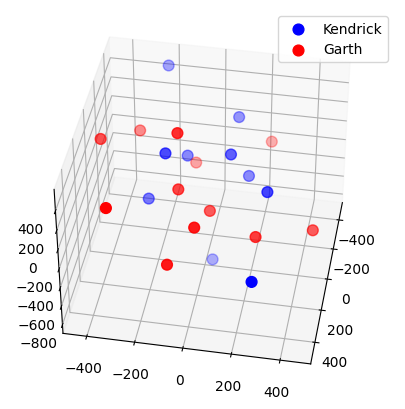

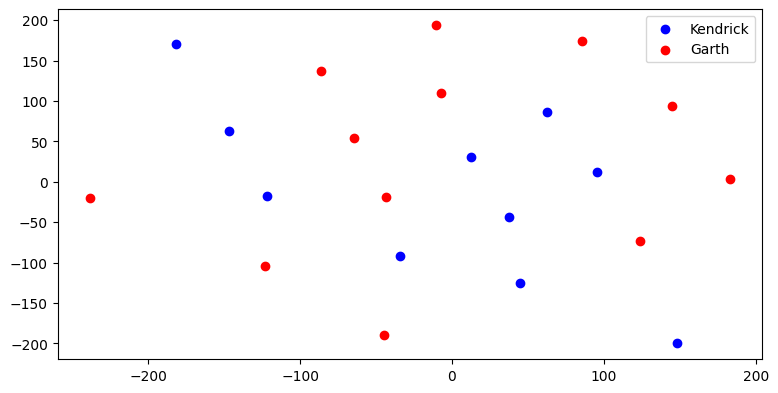

In [25]:
kendrick_3d = transformed_data_3d[:10]
k3_x = [i[0] for i in kendrick_3d]
k3_y = [i[1] for i in kendrick_3d]
k3_z = [i[2] for i in kendrick_3d]

garth_3d = transformed_data_3d[10:]
g3_x = [i[0] for i in garth_3d]
g3_y = [i[1] for i in garth_3d]
g3_z = [i[2] for i in garth_3d]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(k3_x, k3_y, k3_z, c='b', s=60, label='Kendrick')
ax.scatter(g3_x, g3_y, g3_z, c='red', s=60, label='Garth')
ax.view_init(40,10)
ax.legend()
plt.show()

kendrick_2d = transformed_data_2d[:10]
k2_x = [i[0] for i in kendrick_2d]
k2_y = [i[1] for i in kendrick_2d]

garth_2d = transformed_data_2d[10:]
g2_x = [i[0] for i in garth_2d]
g2_y = [i[1] for i in garth_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(k2_x, k2_y, c='b', label='Kendrick')
ax.scatter(g2_x, g2_y, c='red', label='Garth')
ax.legend()
plt.show()

Interesting! Take a crack at interpreting these graphs by answering the following questions below:

What does each graph mean? Do you find one graph more informative than the other? Do you think that this method shows us discernable differences between Kendrick Lamar songs and Garth Brooks songs?  Use the graphs and your understanding of TF-IDF to support your answer.  

In [ ]:
'''
WRITE YOUR ANSWER HERE
'''

## Summary

In this lab, you learned how to:
* Tokenize a corpus of words and identify the different choices to be made while parsing them
* Use a count vectorization strategy to create a bag of words
* Use TF-IDF vectorization with multiple documents to identify words that are important/unique to certain documents
* Visualize and compare vectorized text documents